# Training and evaluation notebook

In [1]:
## imports
import glob
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score

## 1. Construct dataset

In [2]:
# Simply reading the formerly created pickle file, changing it's name to 'merged_df'
# To confirm, you can load and view the combined dataset
with open("combined_dataset.pkl", 'rb') as file:
    merged_df = pd.read_pickle(file)

merged_df


,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,sample_location_id,class
0,0.00495,0.01885,0.03610,0.05020,0.09065,0.13930,0.15855,0.18270,0.19205,0.19175,0.20290,0.1097,201701,2
1,0.01040,0.02405,0.03980,0.05720,0.10385,0.16755,0.19370,0.21600,0.23420,0.24700,0.22290,0.1204,201701,2
2,0.01510,0.02905,0.06635,0.04515,0.12920,0.38280,0.47410,0.49955,0.50775,0.50890,0.24765,0.1219,201701,2
3,0.01345,0.02925,0.06315,0.04920,0.12335,0.28515,0.33710,0.39055,0.37655,0.42050,0.23555,0.1175,201701,2
4,0.01575,0.02970,0.06900,0.04870,0.13360,0.39940,0.49485,0.52430,0.53900,0.48935,0.23950,0.1177,201701,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152806,0.03720,0.04660,0.06660,0.08560,0.13300,0.21200,0.24360,0.26880,0.28690,0.27960,0.28600,0.1640,202312,2
1152807,0.03840,0.04250,0.07690,0.08000,0.14000,0.25190,0.28530,0.34760,0.33920,0.32180,0.29830,0.1563,202312,2
1152808,0.04280,0.04960,0.06970,0.08880,0.12820,0.18960,0.21990,0.25540,0.25480,0.25390,0.27920,0.1567,202312,2
1152809,0.03170,0.04110,0.06480,0.07660,0.13350,0.23340,0.27290,0.30900,0.30940,0.29640,0.30290,0.1617,202312,2


## 2. Add indices

In [3]:
merged_df['NDVI'] = (merged_df['B8'] - merged_df['B4']) / (merged_df['B8'] + merged_df['B4'])

# EVI is an optimized vegetation index designed to enhance the vegetation signal with improved sensitivity in high biomass regions
# It's calculated using the Red (B4), Near-Infrared (B8 or B5), and Blue (B2) bands.
merged_df['EVI'] = 2.5 * (merged_df['B8'] - merged_df['B4']) / (merged_df['B8'] + 6 * merged_df['B4'] - 7.5 * merged_df['B2'] + 1)

# NDWI is used to monitor changes in water content of leaves
# It is typically calculated using the Near-Infrared (B8 or B5) and Short-Wave Infrared (B11 or B6) bands.
merged_df['NDWI'] = (merged_df['B8'] - merged_df['B11']) / (merged_df['B8'] + merged_df['B11'])

# SAVI is a modification of NDVI to correct for the influence of soil brightness
# The standard value of L in the SAVI formula is 0.5.
L = 0.5  # soil brightness correction factor
merged_df['SAVI'] = ((merged_df['B8'] - merged_df['B4']) / (merged_df['B8'] + merged_df['B4'] + L)) * (1 + L)

# GNDVI is used to estimate vegetation health
# It's calculated using the Near-Infrared (B8 or B5) and Green (B3) bands.
merged_df['GNDVI'] = (merged_df['B8'] - merged_df['B3']) / (merged_df['B8'] + merged_df['B3'])

merged_df

,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,sample_location_id,class,NDVI,EVI,NDWI,SAVI,GNDVI
0,0.00495,0.01885,0.03610,0.05020,0.09065,0.13930,0.15855,0.18270,0.19205,0.19175,0.20290,0.1097,201701,2,0.568914,0.246737,-0.052386,0.271183,0.670018
1,0.01040,0.02405,0.03980,0.05720,0.10385,0.16755,0.19370,0.21600,0.23420,0.24700,0.22290,0.1204,201701,2,0.581259,0.287926,-0.015721,0.308070,0.688819
2,0.01510,0.02905,0.06635,0.04515,0.12920,0.38280,0.47410,0.49955,0.50775,0.50890,0.24765,0.1219,201701,2,0.834221,0.731688,0.337125,0.652436,0.765506
3,0.01345,0.02925,0.06315,0.04920,0.12335,0.28515,0.33710,0.39055,0.37655,0.42050,0.23555,0.1175,201701,2,0.776236,0.581962,0.247564,0.544852,0.721622
4,0.01575,0.02970,0.06900,0.04870,0.13360,0.39940,0.49485,0.52430,0.53900,0.48935,0.23950,0.1177,201701,2,0.830017,0.746039,0.372873,0.664865,0.767403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152806,0.03720,0.04660,0.06660,0.08560,0.13300,0.21200,0.24360,0.26880,0.28690,0.27960,0.28600,0.1640,202312,2,0.516930,0.319632,-0.031002,0.321629,0.602862
1152807,0.03840,0.04250,0.07690,0.08000,0.14000,0.25190,0.28530,0.34760,0.33920,0.32180,0.29830,0.1563,202312,2,0.625818,0.443384,0.076328,0.432730,0.637691
1152808,0.04280,0.04960,0.06970,0.08880,0.12820,0.18960,0.21990,0.25540,0.25480,0.25390,0.27920,0.1567,202312,2,0.484021,0.294097,-0.044519,0.296020,0.571209
1152809,0.03170,0.04110,0.06480,0.07660,0.13350,0.23340,0.27290,0.30900,0.30940,0.29640,0.30290,0.1617,202312,2,0.602697,0.397850,0.009969,0.393631,0.653291


In [4]:
# renaming 'class' column to 'classes' to fix python error
merged_df = merged_df.rename(columns={'class': 'classes'})

In the following, I will make some new dataframes for binary classification:

In [5]:
# Step 1: Create a new DataFrame for binary classification
# First, filter out class 3, then collapse classes 0, 1, and 2 into 0.
binary_df = merged_df[merged_df['classes'].isin([0, 1, 2, 4])]
binary_df.loc[binary_df['classes'].isin([0, 1, 2]), 'classes'] = 0

Dropping columns:

In [6]:
binary_df = binary_df.drop('sample_location_id', axis=1)

In [7]:
# Assuming merged_df is your pandas DataFrame
# Shuffle the DataFrame using a random seed, for example, seed=42
binary_df = binary_df.sample(frac=1, random_state=42).reset_index(drop=True)
binary_df

,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,classes,NDVI,EVI,NDWI,SAVI,GNDVI
0,0.03440,0.0407,0.0646,0.0718,0.1222,0.20300,0.2303,0.2618,0.2672,0.2448,0.24540,0.1302,4,0.569544,0.342379,0.032334,0.341891,0.604167
1,0.03890,0.0361,0.0440,0.0609,0.0943,0.13680,0.1612,0.1779,0.1899,0.2191,0.25770,0.1609,0,0.489950,0.229853,-0.183196,0.237547,0.603425
2,0.03040,0.0384,0.0658,0.0421,0.1247,0.34040,0.4195,0.4156,0.4835,0.4696,0.22420,0.1009,0,0.816037,0.676532,0.299156,0.584995,0.726631
3,0.03560,0.0440,0.0616,0.0730,0.1289,0.19880,0.2284,0.2456,0.2668,0.2672,0.28880,0.1660,0,0.541745,0.318780,-0.080838,0.316272,0.598958
4,0.01920,0.0440,0.0682,0.0553,0.1340,0.30050,0.3457,0.3756,0.4086,0.2304,0.22980,0.1123,0,0.743328,0.581349,0.240833,0.516113,0.692654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1096431,0.04060,0.0419,0.0549,0.0668,0.1226,0.20600,0.2362,0.2702,0.2836,0.2701,0.25570,0.1412,4,0.603561,0.374793,0.027572,0.364516,0.662258
1096432,0.02790,0.0327,0.0620,0.0499,0.1269,0.27580,0.3239,0.3592,0.3802,0.3341,0.21140,0.1023,0,0.756050,0.547104,0.259026,0.510340,0.705603
1096433,0.03400,0.0420,0.0575,0.0677,0.1048,0.17110,0.1987,0.2266,0.2301,0.2169,0.22240,0.1283,4,0.539925,0.301449,0.009354,0.300076,0.595213
1096434,0.02255,0.0175,0.0405,0.0228,0.0991,0.20825,0.2438,0.2220,0.2634,0.2628,0.17935,0.0919,0,0.813726,0.405686,0.106266,0.401182,0.691429


## Constructing training and test sets

In [8]:
from sklearn.model_selection import train_test_split

# Assuming your features are all columns except 'classes', and 'classes' is the target variable
X = binary_df.drop('classes', axis=1)  # Features
y = binary_df['classes']  # Target variable

# Perform the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# X_train and y_train will now contain 70% of the data, X_test and y_test will contain 30%

### Classification of binary_df

In this bit I will do a classification based on binary_df which contains classes 0 and 4.
Class 0 is a collapsed class based on the peatland conditions 'actively eroding', 'drained', and 'modified', while class 4 is still 'restored'

In [9]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def objective(trial):
    # Hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 50, 400)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_float('min_samples_split', 0.1, 1.0)
    min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.1, 0.5)
    
    
    # Initialize the classifier with the current hyperparameters
    clf = RandomForestClassifier(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    # Train the classifier
    clf.fit(X_train, y_train)
    
    # Predict on the validation set
    predictions = clf.predict(X_test)
    
    # Compute and return the accuracy
    accuracy = accuracy_score(y_test, predictions)
    return accuracy

C:\Users\klara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  # Adjust the number of trials as needed

print(f"Best trial: {study.best_trial.params}")

[I 2024-02-12 12:15:34,124] A new study created in memory with name: no-name-ea91c067-eb47-4124-a76e-3008f1f7477b
[I 2024-02-12 12:16:22,291] Trial 0 finished with value: 0.7720038549118204 and parameters: {'n_estimators': 116, 'max_depth': 6, 'min_samples_split': 0.32282974849030754, 'min_samples_leaf': 0.1915728313284759}. Best is trial 0 with value: 0.7720038549118204.
[I 2024-02-12 12:16:38,609] Trial 1 finished with value: 0.7720038549118204 and parameters: {'n_estimators': 209, 'max_depth': 4, 'min_samples_split': 0.9066794928636984, 'min_samples_leaf': 0.2176713609821563}. Best is trial 0 with value: 0.7720038549118204.
[I 2024-02-12 12:16:53,721] Trial 2 finished with value: 0.7720038549118204 and parameters: {'n_estimators': 183, 'max_depth': 28, 'min_samples_split': 0.18151969269520807, 'min_samples_leaf': 0.4678307131532643}. Best is trial 0 with value: 0.7720038549118204.
[I 2024-02-12 12:17:04,646] Trial 3 finished with value: 0.7720038549118204 and parameters: {'n_estimat

Best trial: {'n_estimators': 116, 'max_depth': 6, 'min_samples_split': 0.32282974849030754, 'min_samples_leaf': 0.1915728313284759}


RF model based on bands only:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score

features = binary_df[['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']].values
target = binary_df['classes'].values

# Assuming features and target are already defined
skf = StratifiedKFold(n_splits=best_k, shuffle=True, random_state=42)

rf_bands_binary_1_accuracy_scores = []
rf_bands_binary_1_precision_scores = []
rf_bands_binary_1_recall_scores = []
rf_bands_binary_1_f1_scores = []

for train_index, test_index in skf.split(features, target):
    rf_bands_binary_1_X_train, rf_bands_binary_1_X_test = features[train_index], features[test_index]
    rf_bands_binary_1_y_train, rf_bands_binary_1_y_test = target[train_index], target[test_index]

    rf_bands_binary_1_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_bands_binary_1_model.fit(rf_bands_binary_1_X_train, rf_bands_binary_1_y_train)

    rf_bands_binary_1_y_pred = rf_bands_binary_1_model.predict(rf_bands_binary_1_X_test)

    rf_bands_binary_1_accuracy_scores.append(accuracy_score(rf_bands_binary_1_y_test, rf_bands_binary_1_y_pred))
    rf_bands_binary_1_precision_scores.append(precision_score(rf_bands_binary_1_y_test, rf_bands_binary_1_y_pred, average='macro'))
    rf_bands_binary_1_recall_scores.append(recall_score(rf_bands_binary_1_y_test, rf_bands_binary_1_y_pred, average='macro'))
    rf_bands_binary_1_f1_scores.append(f1_score(rf_bands_binary_1_y_test, rf_bands_binary_1_y_pred, average='macro'))

# Calculate the average scores across all folds
rf_bands_binary_1_average_accuracy = np.mean(rf_bands_binary_1_accuracy_scores)
rf_bands_binary_1_average_precision = np.mean(rf_bands_binary_1_precision_scores)
rf_bands_binary_1_average_recall = np.mean(rf_bands_binary_1_recall_scores)
rf_bands_binary_1_average_f1 = np.mean(rf_bands_binary_1_f1_scores)

print(f"Binary 1 RF Bands Average Accuracy: {rf_bands_binary_1_average_accuracy}")
print(f"Binary 1 RF Bands Average Precision: {rf_bands_binary_1_average_precision}")
print(f"Binary 1 RF Bands Average Recall: {rf_bands_binary_1_average_recall}")
print(f"Binary 1 RF Bands Average F1 Score: {rf_bands_binary_1_average_f1}")

RF model based on both bands and VIs:

In [ ]:
features = binary_df[['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'NDVI', 'EVI', 'NDWI', 'SAVI', 'GNDVI']].values
target = binary_df['classes'].values

# Assuming features and target are already defined
skf = StratifiedKFold(n_splits=best_k, shuffle=True, random_state=42)

rf_all_binary_1_accuracy_scores = []
rf_all_binary_1_precision_scores = []
rf_all_binary_1_recall_scores = []
rf_all_binary_1_f1_scores = []

for train_index, test_index in skf.split(features, target):
    rf_all_binary_1_X_train, rf_all_binary_1_X_test = features[train_index], features[test_index]
    rf_all_binary_1_y_train, rf_all_binary_1_y_test = target[train_index], target[test_index]

    rf_all_binary_1_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_all_binary_1_model.fit(rf_all_binary_1_X_train, rf_all_binary_1_y_train)

    rf_all_binary_1_y_pred = rf_all_binary_1_model.predict(rf_all_binary_1_X_test)

    rf_all_binary_1_accuracy_scores.append(accuracy_score(rf_all_binary_1_y_test, rf_all_binary_1_y_pred))
    rf_all_binary_1_precision_scores.append(precision_score(rf_all_binary_1_y_test, rf_all_binary_1_y_pred, average='macro'))
    rf_all_binary_1_recall_scores.append(recall_score(rf_all_binary_1_y_test, rf_all_binary_1_y_pred, average='macro'))
    rf_all_binary_1_f1_scores.append(f1_score(rf_all_binary_1_y_test, rf_all_binary_1_y_pred, average='macro'))

# Calculate the average scores across all folds
rf_all_binary_1_average_accuracy = np.mean(rf_all_binary_1_accuracy_scores)
rf_all_binary_1_average_precision = np.mean(rf_all_binary_1_precision_scores)
rf_all_binary_1_average_recall = np.mean(rf_all_binary_1_recall_scores)
rf_all_binary_1_average_f1 = np.mean(rf_all_binary_1_f1_scores)

print(f"Binary 1 RF Bands and VIs Average Accuracy: {rf_all_binary_1_average_accuracy}")
print(f"Binary 1 RF Bands and VIs Average Precision: {rf_all_binary_1_average_precision}")
print(f"Binary 1 RF Bands and VIs Average Recall: {rf_all_binary_1_average_recall}")
print(f"Binary 1 RF Bands and VIs Average F1 Score: {rf_all_binary_1_average_f1}")

RF Optuna hyperparameter optimisation based on only bands:

In [11]:
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

features = binary_df[['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']].values
target = binary_df['classes'].values

# Assuming 'best_k' is defined based on your previous analysis
# Assuming 'features' and 'target' are already defined as per your dataset

def objective(trial):
    # Hyperparameters to be optimized
    n_estimators = trial.suggest_int('n_estimators', 10, 500)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 16)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 16)
    
    # Initialize the RandomForestClassifier with suggested hyperparameters
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                 min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                 random_state=42)
    
    # Create StratifiedKFold object with 'best_k' folds
    skf = StratifiedKFold(n_splits=best_k, shuffle=True, random_state=42)
    
    # Use cross-validation to evaluate model performance, passing the SKF object
    scores = cross_val_score(clf, features, target, cv=skf, scoring='accuracy')
    
    # Return the average of the cross-validation scores
    return np.mean(scores)

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  # Adjust n_trials based on your computational budget

# Print the best hyperparameters found
print('Best trial:', study.best_trial.params)

C:\Users\klara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-02-08 16:52:18,854] A new study created in memory with name: no-name-b133f83a-24ee-472e-acba-d2abe3bce4bc
[I 2024-02-08 17:44:04,956] Trial 0 finished with value: 0.86581432933614 and parameters: {'n_estimators': 337, 'max_depth': 13, 'min_samples_split': 10, 'min_samples_leaf': 13}. Best is trial 0 with value: 0.86581432933614.
[I 2024-02-08 18:22:28,791] Trial 1 finished with value: 0.8423711005475923 and parameters: {'n_estimators': 477, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 13}. Best is trial 0 with value: 0.86581432933614.
[I 2024-02-08 18:30:33,231] Trial 2 finished with value: 0.7864508279553024 and parameters

Best trial: {'n_estimators': 278, 'max_depth': 32, 'min_samples_split': 2, 'min_samples_leaf': 1}


Hyperparameter optimisation based on bands and VIs:

In [12]:
features = binary_df[['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'NDVI', 'EVI', 'NDWI', 'SAVI', 'GNDVI']].values
target = binary_df['classes'].values

# Assuming 'best_k' is defined based on your previous analysis
# Assuming 'features' and 'target' are already defined as per your dataset

def objective(trial):
    # Hyperparameters to be optimized
    n_estimators = trial.suggest_int('n_estimators', 10, 500)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 16)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 16)
    
    # Initialize the RandomForestClassifier with suggested hyperparameters
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                 min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                 random_state=42)
    
    # Create StratifiedKFold object with 'best_k' folds
    skf = StratifiedKFold(n_splits=best_k, shuffle=True, random_state=42)
    
    # Use cross-validation to evaluate model performance, passing the SKF object
    scores = cross_val_score(clf, features, target, cv=skf, scoring='accuracy')
    
    # Return the average of the cross-validation scores
    return np.mean(scores)

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  # Adjust n_trials based on your computational budget

# Print the best hyperparameters found
print('Best trial:', study.best_trial.params)

[I 2024-02-09 03:09:58,537] A new study created in memory with name: no-name-4578396c-8942-4eb9-a263-d9c84c3d9d9c
[I 2024-02-09 03:55:33,325] Trial 0 finished with value: 0.8303667519125604 and parameters: {'n_estimators': 472, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 13}. Best is trial 0 with value: 0.8303667519125604.
[I 2024-02-09 03:58:53,585] Trial 1 finished with value: 0.7930376237190315 and parameters: {'n_estimators': 81, 'max_depth': 4, 'min_samples_split': 14, 'min_samples_leaf': 14}. Best is trial 0 with value: 0.8303667519125604.
[I 2024-02-09 04:06:05,905] Trial 2 finished with value: 0.7917388703034194 and parameters: {'n_estimators': 332, 'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8303667519125604.
[I 2024-02-09 04:10:20,491] Trial 3 finished with value: 0.7917516389465504 and parameters: {'n_estimators': 199, 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 0 with value:

Best trial: {'n_estimators': 25, 'max_depth': 30, 'min_samples_split': 16, 'min_samples_leaf': 8}


### Evaluation for bands only:

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
import numpy as np

# Assuming features (X) and target (y) are already defined based on your dataset
X = binary_df[['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']]
y = binary_df['classes']

# Best trial: {'n_estimators': 278, 'max_depth': 32, 'min_samples_split': 2, 'min_samples_leaf': 1}

# Optimal parameters from hyperparameter optimization
optimal_params = {
    'n_estimators': 278,
    'max_depth': 32,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'random_state': 42  # Ensuring reproducibility
}

# Initialize the StratifiedKFold object
n_splits = best_k  # Assuming best_k is defined based on your previous code
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store evaluation metrics for each fold
precision_list = []
recall_list = []
accuracy_list = []
f1_list = []  # If you want to calculate F1 score as well
kappa_list = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Instantiate the RandomForestClassifier with the optimal parameters
    classifier = RandomForestClassifier(**optimal_params)

    # Train the classifier on the training set
    classifier.fit(X_train, y_train)

    # Predict on the testing set
    y_pred = classifier.predict(X_test)

    # Calculate and append the evaluation metrics for the current fold
    precision_list.append(precision_score(y_test, y_pred, average='weighted'))
    recall_list.append(recall_score(y_test, y_pred, average='weighted'))
    accuracy_list.append(accuracy_score(y_test, y_pred))
    f1_list.append(f1_score(y_test, y_pred, average='weighted'))  # Calculate F1 score
    kappa_list.append(cohen_kappa_score(y_test, y_pred))  # Calculate Cohen's Kappa score

# Calculate average metrics across all folds
average_precision = np.mean(precision_list)
average_recall = np.mean(recall_list)
average_accuracy = np.mean(accuracy_list)
average_f1 = np.mean(f1_list)  # Average F1 score
average_kappa = np.mean(kappa_list)  # Average Cohen's Kappa score

# Print the average metrics
print(f"Average Precision: {average_precision}")
print(f"Average Recall: {average_recall}")
print(f"Average Accuracy: {average_accuracy}")
print(f"Average F1 Score: {average_f1}")
print(f"Average Kappa Score: {average_kappa}")  # Print Average Cohen's Kappa Score


Average Precision: 0.9566647167693674
Average Recall: 0.9559782787139423
Average Accuracy: 0.9559782787139423
Average F1 Score: 0.9547020119912459
Average Kappa Score: 0.8679483763332183


- You'll also want to output an aggregated prediction confusion matrix (from the cross-validation), preferably as a seaborn (sns) figure. 

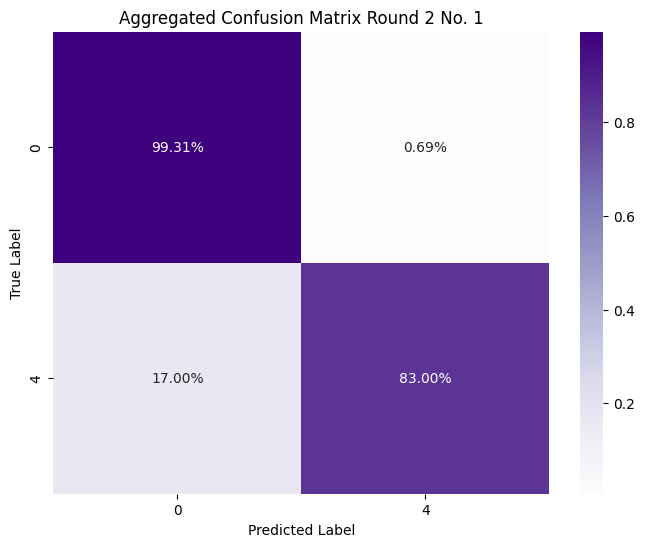

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize the StratifiedKFold object
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists to collect true and predicted labels across all folds
true_labels = []
predicted_labels = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Instantiate and train the RandomForestClassifier with the optimal parameters
    classifier = RandomForestClassifier(**optimal_params)
    classifier.fit(X_train, y_train)

    # Predict on the test set
    y_pred = classifier.predict(X_test)

    # Append true and predicted labels for later aggregation
    true_labels.extend(y_test)
    predicted_labels.extend(y_pred)

# Compute the confusion matrix with normalization
cm_normalized = confusion_matrix(true_labels, predicted_labels, normalize='true')

# Visualize the aggregated confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap="Purples", xticklabels=[0, 4], yticklabels=[0, 4])
plt.title('Aggregated Confusion Matrix Round 2 No. 1')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Feature permutation importance

In [23]:
## run feature permutation importance here. 
## Gives you an indication of which features are the most important for good classification performance

from sklearn.inspection import permutation_importance

# Assuming 'classifier' is your already trained RandomForestClassifier instance

# Perform permutation importance using the pre-trained classifier
result = permutation_importance(classifier, X, y, n_repeats=5, random_state=42, n_jobs=-1)

# Get the importance of each feature
feature_importance = result.importances_mean

# Optionally, sort the features by importance
sorted_idx = feature_importance.argsort()

# Visualize the feature importances
plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center', color='darkpurple')
plt.yticks(range(len(sorted_idx)), X.columns[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance Round 2 No. 1')
plt.show()


BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

### Evaluation for bands and VIs:

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Assuming features (X) and target (y) are already defined based on your dataset
X = binary_df[['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'NDVI', 'EVI', 'NDWI', 'SAVI', 'GNDVI']]
y = binary_df['classes']

# Best trial: {'n_estimators': 25, 'max_depth': 30, 'min_samples_split': 16, 'min_samples_leaf': 8}

# Optimal parameters from hyperparameter optimization
optimal_params = {
    'n_estimators': 25,
    'max_depth': 30,
    'min_samples_split': 16,
    'min_samples_leaf': 8,
    'random_state': 42  # Ensuring reproducibility
}

# Initialize the StratifiedKFold object
n_splits = best_k  # Assuming best_k is defined based on your previous code
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store evaluation metrics for each fold
precision_list = []
recall_list = []
accuracy_list = []
f1_list = []  # If you want to calculate F1 score as well

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Instantiate the RandomForestClassifier with the optimal parameters
    classifier = RandomForestClassifier(**optimal_params)

    # Train the classifier on the training set
    classifier.fit(X_train, y_train)

    # Predict on the testing set
    y_pred = classifier.predict(X_test)

    # Calculate and append the evaluation metrics for the current fold
    precision_list.append(precision_score(y_test, y_pred, average='weighted'))
    recall_list.append(recall_score(y_test, y_pred, average='weighted'))
    accuracy_list.append(accuracy_score(y_test, y_pred))
    f1_list.append(f1_score(y_test, y_pred, average='weighted'))  # Calculate F1 score

# Calculate average metrics across all folds
average_precision = np.mean(precision_list)
average_recall = np.mean(recall_list)
average_accuracy = np.mean(accuracy_list)
average_f1 = np.mean(f1_list)  # Average F1 score

# Print the average metrics
print(f"Average Precision: {average_precision}")
print(f"Average Recall: {average_recall}")
print(f"Average Accuracy: {average_accuracy}")
print(f"Average F1 Score: {average_f1}")

Average Precision: 0.9185526395454972
Average Recall: 0.9177872671090697
Average Accuracy: 0.9177872671090697
Average F1 Score: 0.9132658103739658


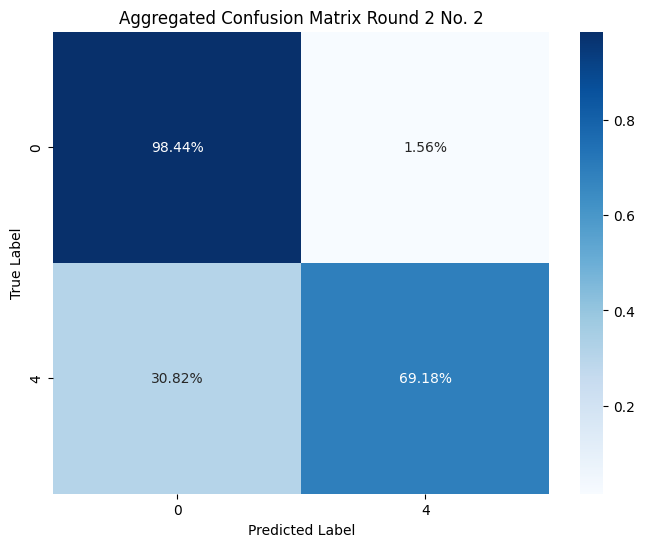

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming features (X) and target (y) are already defined based on your dataset
X = binary_df[['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'NDVI', 'EVI', 'NDWI', 'SAVI', 'GNDVI']]
y = binary_df['classes']

# Best trial: {'n_estimators': 25, 'max_depth': 30, 'min_samples_split': 16, 'min_samples_leaf': 8}

# Optimal parameters from hyperparameter optimization
optimal_params = {
    'n_estimators': 25,
    'max_depth': 30,
    'min_samples_split': 16,
    'min_samples_leaf': 8,
    'random_state': 42  # Ensuring reproducibility
}

# Initialize the StratifiedKFold object
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists to collect true and predicted labels across all folds
true_labels = []
predicted_labels = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Instantiate and train the RandomForestClassifier with the optimal parameters
    classifier = RandomForestClassifier(**optimal_params)
    classifier.fit(X_train, y_train)

    # Predict on the test set
    y_pred = classifier.predict(X_test)

    # Append true and predicted labels for later aggregation
    true_labels.extend(y_test)
    predicted_labels.extend(y_pred)

# Compute the confusion matrix with normalization
cm_normalized = confusion_matrix(true_labels, predicted_labels, normalize='true')

# Visualize the aggregated confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap="Blues", xticklabels=[0, 4], yticklabels=[0, 4])
plt.title('Aggregated Confusion Matrix Round 2 No. 2')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

kappa_list = []
kappa_list.append(cohen_kappa_score(y_test, y_pred))  # Calculate Cohen's Kappa score
average_kappa = np.mean(kappa_list)  # Average Cohen's Kappa score
print(f"Average Kappa Score: {average_kappa}")  # Print Average Cohen's Kappa Score

Average Kappa Score: 0.7446579066679935
